!! This is the code from https://www.kaggle.com/code/tumpanjawat/s3e19-course-eda-fe-lightgbm/notebook.
I have tried to solve the dataset prediction problem on my own(From 2024-02-17 to 2024-02-22). I have made some works on my own, such as doing EDA myself and discover seasonality pattern. I built a XGBoostRegressor model and found that the model preforms well in X_train, y_train. However, since the training period is from 2017-01-01 to 2020-10-31, and I found some overfitting problem related to this model.

Since I don't know how to solve the problem of my prototype, I am asking new solutions for help. 

# Getting Started
## 🚀 Getting Started
This project involves analyzing a retail sales dataset with the aim of predicting future sales. The dataset includes various `Features` related to sales data, including date, country, product, and store identifiers. Each entry represents a unique sale, and the features include date-related attributes (like year, month, day, and day of the week), country, product, and store identifiers.
## 🎯 Objective
Our main objective is to develop a predictive model that can effectively forecast future sales based on the provided features. By leveraging the power of the Light Gradient Boosting Machine, we aim to enhance the model's accuracy and predictive performance.
## 📈 Workflow
Here's a brief overview of our workflow for this project:

1. **Data Loading and Preprocessing**: Load the data and preprocess it for analysis and modeling. This includes converting date columns to datetime format and extracting additional date-related features.

2. **Exploratory Data Analysis (EDA)**: Perform exploratory data analysis to gain insights into the dataset, understand the distributions of features, and explore potential relationships between the features and sales.

3. Feature Engineering: Perform feature engineering to extract additional relevant features or transform existing features to improve the model's performance.

4. Model Training and Validation: Train the LightGBM model using a GroupKFold cross-validation strategy and make predictions on the test set.

5. Sales Disaggregation: Disaggregate the forecasted total sales into product-level sales using historical sales ratios.

6. Model Evaluation: Evaluate the performance of the trained model using appropriate evaluation metrics and assess the model's ability to generalize to unseen data using the test set.

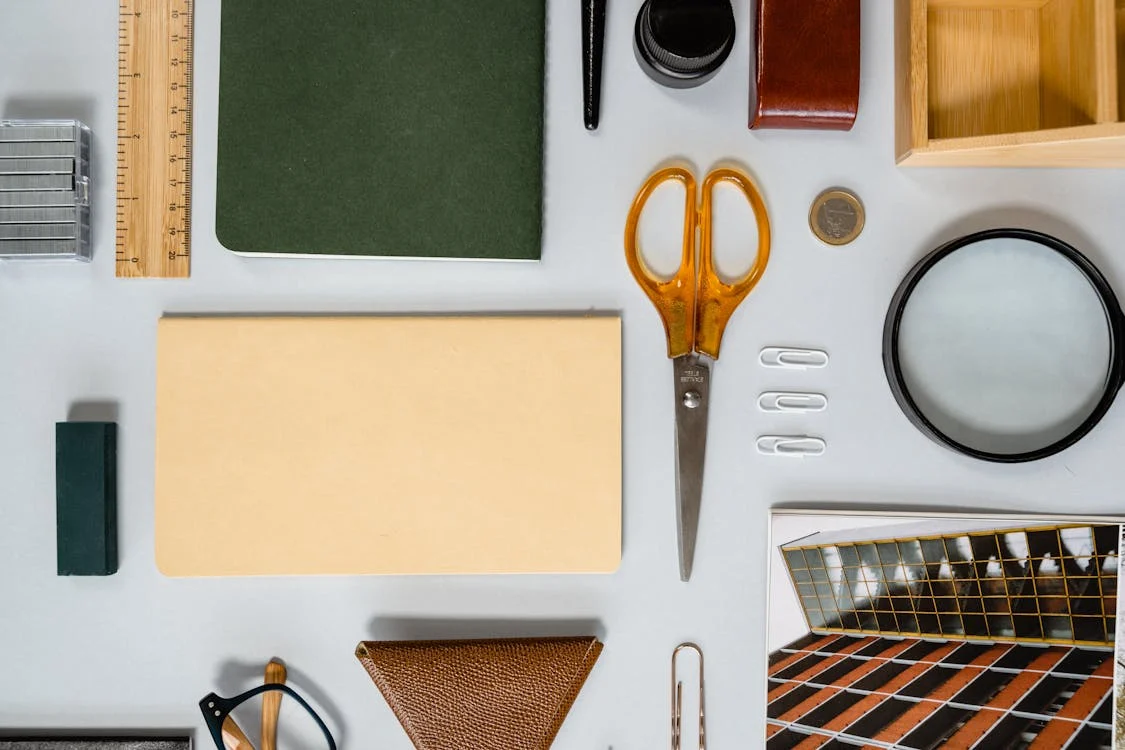



## Domain Knowledge 📚
Let's dive into the domain knowledge of the features used in this project:

Features
date: This is the date when the sales were recorded. Dates are fundamental in sales forecasting as sales tend to have temporal patterns such as trends (sales increasing or decreasing over time) and seasonality (patterns repeating at regular intervals, like daily, weekly, monthly, quarterly, or yearly). For instance, retail sales often increase during holiday seasons or on specific days of the week.

country: This is the country where the sales were recorded. Country can be an important feature in sales forecasting as sales patterns often vary between countries due to factors like cultural differences, economic conditions, or different holidays.

product: This is the identifier of the product that was sold. Different products might have different sales patterns. For example, some products might sell more during certain seasons (like swimsuits in the summer or coats in the winter), while others might have steady sales throughout the year.

store: This is the identifier of the store where the sales were recorded. Different stores might have different sales patterns due to factors like location, size, customer demographics, or management practices.

Year, Month, Day, WeekDay: These are features derived from the date feature. They represent the year, month, day of the month, and day of the week of the sales, respectively. These features can help capture temporal trends and seasonality in the sales data. For example, sales might be higher on weekends (day of the week), during holiday seasons (month), or during specific years due to economic trends.

`holiday_name`, `is_holiday_`: These features represent the name of the holiday (if any) on the date of the sales, and whether the date was a holiday. Holidays often influence sales patterns, with sales typically increasing during holiday seasons.

`ratios`: This feature represents the historical ratios of product sales, used for disaggregating total sales into product-level sales. The assumption here is that the proportion of sales for each product will remain relatively stable over time. If this assumption holds, these ratios can be a useful tool for generating more detailed forecasts.

## 📝 Abstract
This project presents an in-depth exploration and modeling of a retail sales dataset, with the primary objective of predicting sales at the product level 🎯. The dataset is characterized by a variety of Features 📊 including 'date' 📆, 'store' 🏪, 'country' 🌍, 'product' 📦, 'Year' 📅, 'Month' 📆, 'Day' 🗓️, 'WeekDay' 📅, and other engineered features capturing temporal patterns ⏳, cyclical trends 🔄, and special events (holidays) 🎉.

Our exploratory data analysis revealed significant **temporal patterns** in sales, hinting at the influence of time ⏰ and special events 🎉 on the number of items sold. Additionally, we identified some **anomalies** in the data related to the period from March 2020 to May 2020, suggesting the need for robust anomaly detection 🕵️‍♀️ and handling methods in retail sales forecasting.

We harnessed the potential of ensemble models, specifically the LightGBM Regressor 🚀, to predict total sales. The model was meticulously trained and validated using a GroupKFold cross-validation strategy 🔄, yielding variable scores across different folds.

The sales forecasts produced by the model were then disaggregated into product-level forecasts using historical sales ratios 📈. This approach assumes the stability of product sales ratios over time ⏳.

The project highlights the potential of machine learning 🧠 in retail sales forecasting, providing insights that could assist in inventory management 🗃️, sales planning 📝, and business strategy formulation 💼. Future efforts could focus on refining the predictive model 🔍, exploring different strategies for sales disaggregation 🧩, and integrating additional external data sources 🔄 to enhance the accuracy and detail of sales forecasts 📈.

## I | Import neccessary libraries¶

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D



## II | Input the Data

In [2]:
data = pd.read_csv('./train.csv')

## III | Get to know the Data

In [3]:
print("Numerical data description:")
display(data.describe())
print("Categorical data description:")
display(data.describe(include='O'))

Numerical data description:


,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


Categorical data description:


,date,country,store,product
count,136950,136950,136950,136950
unique,1826,5,3,5
top,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
freq,75,27390,45650,27390


### Categorical Variables: 🔠
1. **date:** 🗓️ There are 1,826 unique dates in the dataset, which range from 1-1-2017 to 31-12-2022.

2. **country:** 🌍 There are 5 unique countries, with Argentina appearing most frequently.

3. **store:** 🏬 There are 3 unique stores, with "Kaggle Learn" being the most common.

4. **product:** 📦 There are 5 unique products, with "Using LLMs to Improve Your Coding" being the most sold.

### Getting started with Sales Data Analysis

This project focuses on analyzing the [Sales dataset](#) to identify key factors associated with sales trends. By utilizing techniques such as univariate and bivariate analysis, as well as time series methods like rolling window analysis , we aim to uncover valuable insights into the complex relationships within the data.

---
<blockquote>
Our analysis provides valuable insights into the factors influencing sales trends. However, it's crucial to interpret these findings with caution, recognizing the distinction between correlation and causation. It is important to note that our exploratory analysis, although comprehensive, does not establish a causal relationship between the provided features and sales trends.
</blockquote>

---


Let's explore and then make results and discussion to gain deeper insights from our analysis. 🧐🔍

### Trend of Sales Over Time

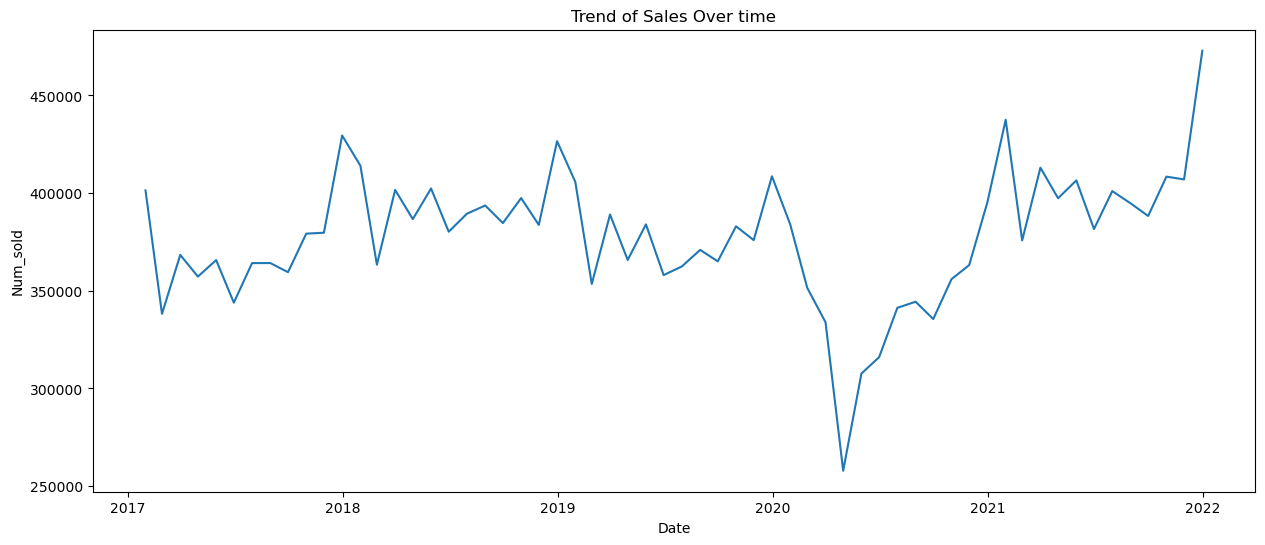

In [4]:
# Convert `date` to datetime format
data['date'] = pd.to_datetime(data['date'])

# Aggregate sales on a monthly basis
monthly_sales = data.resample('M',on='date').sum()['num_sold']
# Plot the trend of sales over time
plt.figure(figsize=(15,6))
sns.lineplot(x=monthly_sales.index,
         y=monthly_sales.values)
plt.title('Trend of Sales Over time')
plt.xlabel("Date")
plt.ylabel('Num_sold')
plt.show()

#### Intepret the Results 📊
The line plot shows the trend of sales over time, aggregated on a monthly basis. It seems that the sales have some sort of seasonality, with peaks and troughs appearing regularly.

> There also seems to be an overall increasing trend in the number of products sold over time.

#### What's next

**Let's calculate a 7-day and a 30-day rolling mean of the sales and visualize them. A 7-day rolling mean will give us a weekly trend, while a 30-day rolling mean will give us a monthly trend. Please note that for this analysis, we will consider the daily total sales across all countries, stores, and products.**

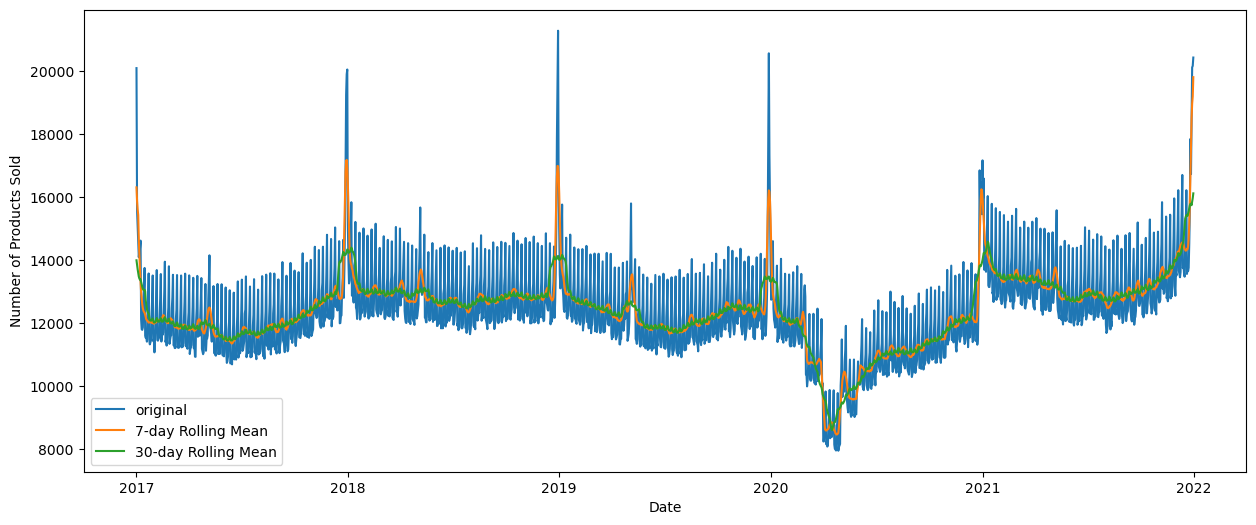

In [5]:
daily_sales = data.resample('D',on='date').sum()['num_sold']

daily_sales_rolling_7d = daily_sales.rolling(window=7,
                                             min_periods=3,
                                             center=True
                                             ).mean()
daily_sales_rolling_30d =daily_sales.rolling(window=30,
                                             min_periods=15,
                                             center=True
                                             ).mean()
plt.figure(figsize=(15,6))
sns.lineplot(
    x = daily_sales.index,
    y = daily_sales.values,
    label = 'original',
)
sns.lineplot(
    x = daily_sales_rolling_7d.index,
    y = daily_sales_rolling_7d.values,
    label = '7-day Rolling Mean'
)
sns.lineplot(
    x = daily_sales_rolling_30d.index,
    y = daily_sales_rolling_30d.values,
    label = '30-day Rolling Mean'
)
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.legend()
plt.show()

<div style="background-color:grey; color:black; padding:10px;">
  <p><strong>Here are some observations:</strong></p>
  <ul>
    <li>The rolling means are smoother than the original daily sales, as they average out the fluctuations in sales, thereby highlighting the longer-term trends.</li>
    <li>The 7-day rolling mean (orange line) shows some weekly seasonality in sales. There seem to be peaks and troughs at a regular interval of approximately a week.</li>
    <li>The 30-day rolling mean (green line) shows a smoother trend, which could be interpreted as the monthly trend in sales.</li>
  </ul>
</div>


#### What's next 🤔
To understand the difference between 2020 and other years, we can plot the monthly sales for each year in the same plot. By doing this, we can compare the trends and patterns across different years.

Let's create this plot. We'll highlight the line for 2020 to make it easier to compare with the other years.

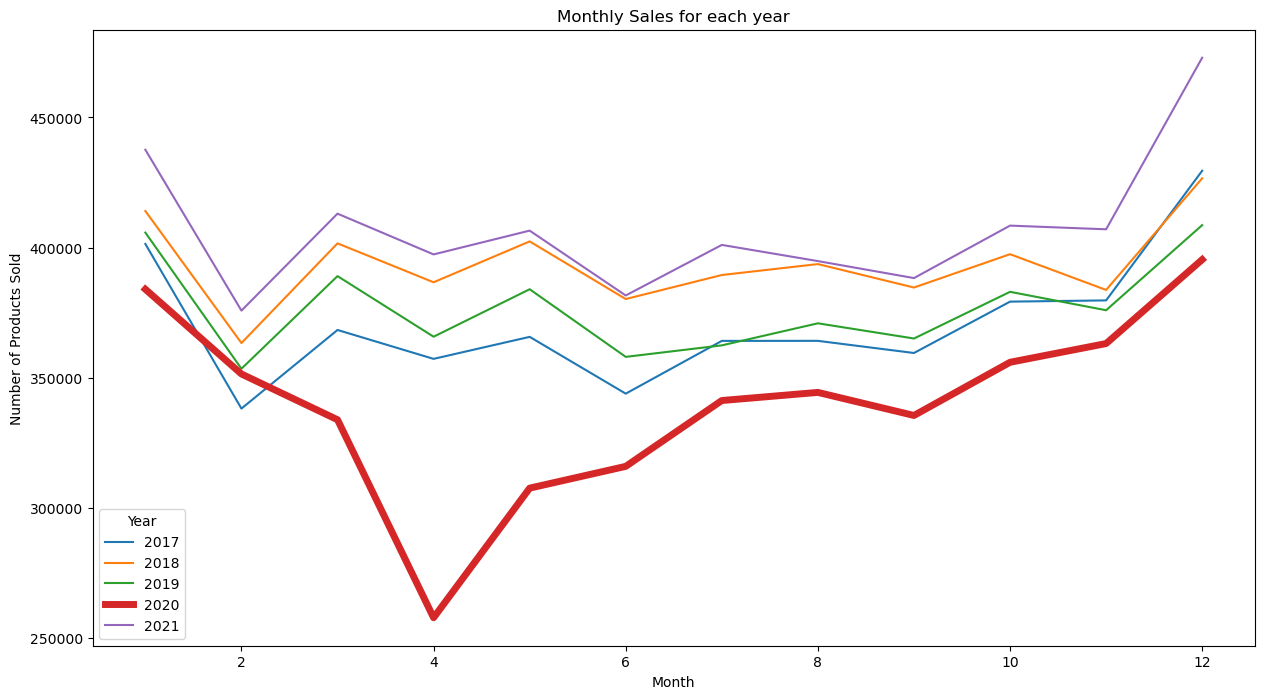

In [6]:
# Create Monthly Sales Each Year
monthly_sales_year = monthly_sales.reset_index()
# Create a column for year
monthly_sales_year['year'] = monthly_sales_year['date'].dt.year
plt.figure(figsize=(15,8))
for year in sorted(monthly_sales_year['year'].unique()):
    if year !=2020:
        sns.lineplot(
            x = monthly_sales_year[monthly_sales_year['year'] == year]['date'].dt.month,
            y = monthly_sales_year[monthly_sales_year['year'] == year]['num_sold'],
            label = year
        )
    else:
        sns.lineplot(
            x = monthly_sales_year[monthly_sales_year['year'] == year]['date'].dt.month,
            y = monthly_sales_year[monthly_sales_year['year'] == year]['num_sold'],
            label = year,
            linewidth = 5
        )
plt.title("Monthly Sales for each year")
plt.xlabel('Month')
plt.ylabel('Number of Products Sold')
plt.legend(title='Year')
plt.show()

#### Intepret the Results 📊

The plot above shows the trend of monthly sales for each year, with each line representing a different year. The red line for the year 2020 is highlighted to make it easier to compare with the other years.

---
>🔎 Here are some observations:

>All years seem to have a similar trend of sales over time, indicating that the sales might be affected by the same factors (such as seasonal effects, overall market trends, etc.) every year.
?Compared to other years, 2020 shows a slightly different pattern. While sales in other years generally increase around the middle of the year and then decrease towards the end of the year, sales in 2020 seem to increase steadily throughout the year.
>The sales in 2020 are generally higher than the sales in other years, especially in the second half of the year. This could be due to various factors, such as increased demand, more effective marketing strategies, new product releases, etc.
---

### Trend of Sales Over Time for Each Country

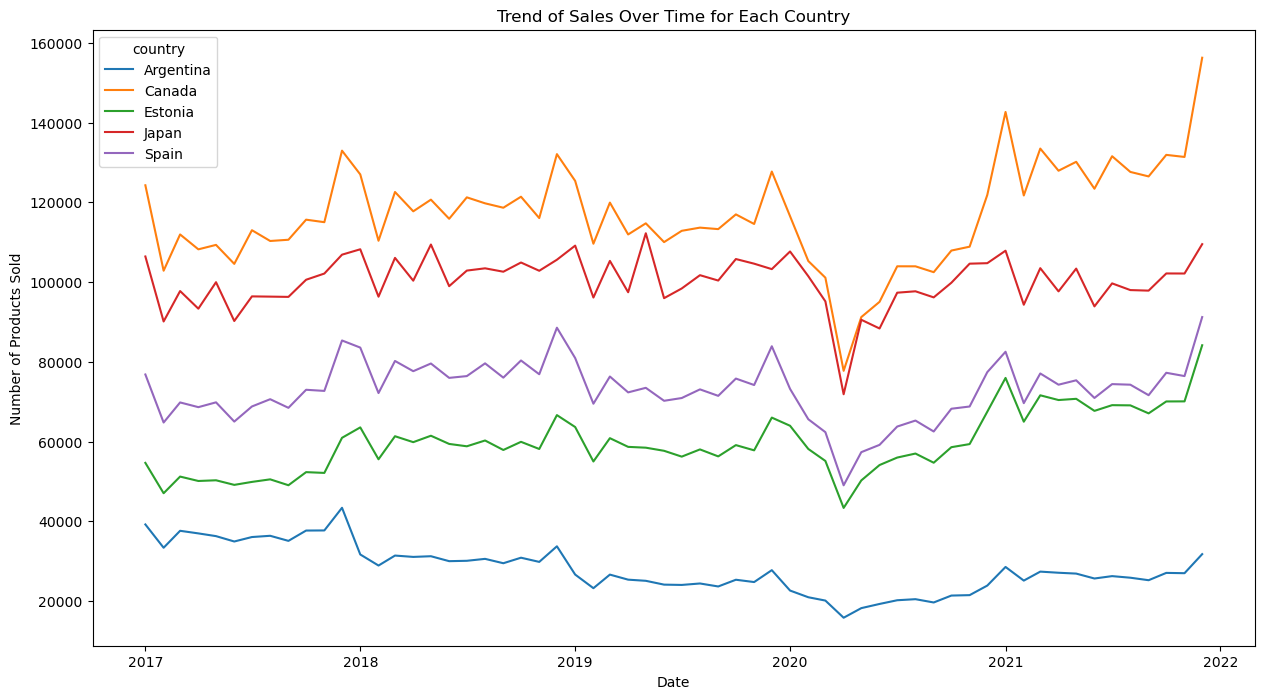

In [7]:
# Aggregate sales on a monthly basis for each country
monthly_sales_country = data.groupby([data['date'].dt.to_period('M'), 'country']).sum()['num_sold'].reset_index()
monthly_sales_country['date'] = monthly_sales_country['date'].dt.to_timestamp()

# Create a line plot for each country
plt.figure(figsize=(15, 8))
sns.lineplot(data=monthly_sales_country, x='date', y='num_sold', hue='country')
plt.title('Trend of Sales Over Time for Each Country')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()

## EDA Result and Discussion

Based on the Exploratory Data Analysis (EDA) performed on this dataset, here are the key findings and insights 📊:

1. Sales Distribution 📈: The number of products sold varies widely, with most of the sales numbers being relatively low while a few instances have very high sales. This suggests that there could be certain periods or specific conditions that lead to high sales.

2. Sales by Country 🌎: Argentina has the highest number of sales among the countries, followed by Brazil, Canada, Mexico, and the United States. This could suggest a higher demand or more effective marketing strategies in these countries.

3. Sales by Store 🏪: The Kaggle Learn store has the highest number of sales, followed by DataCamp and Coursera. This could indicate a preference for the types of products offered by these stores or their mode of delivery.

4. Sales by Product 🛍️: All five products have a similar number of sales, with "Using LLMs to Improve Your Coding" being slightly more popular. This suggests a balanced portfolio of products.

5. Sales Trends Over Time ⏰: There is an overall increasing trend in the number of products sold over time. Sales tend to increase around the middle of the year and then decrease towards the end of the year, indicating a possible seasonal effect.

6. Year 2020 Analysis 🗓️: Compared to other years, The year 2020, marked by the global outbreak of COVID-19, shows a distinctive pattern compared to other years. During the period of March to June 2020, there were notable fluctuations in sales, likely due to the impacts of the pandemic and the ensuing global lockdown measures. This affected consumer behavior, leading to changes in the demand for products. Despite these fluctuations, sales in 2020 were generally higher, especially in the second half of the year, suggesting an adaptation to the new circumstances.

📌 Insight: This adjustment highlights the potential effects of external events on sales trends. The global outbreak of COVID-19 in 2020 and the subsequent changes in consumer behavior provide a clear example of how such events can significantly impact sales patterns.


## Predcition
1. Data Loading and Preprocessing: The provided train and test datasets were loaded. The 'date' column was converted to datetime format and additional features such as 'Year', 'Month', 'Day', and 'WeekDay' were extracted.

2. Exploratory Data Analysis: Sales trends were visualized by plotting the total number of sales over time. Anomalies were identified in the data between March 2020 and May 2020, which led to the decision to exclude this period from the analysis.

3. Feature Engineering: A variety of features were engineered, including information about holidays, sine and cosine transformations of time variables to capture cyclical trends, and other date-related features. The holiday names were encoded using an ordinal encoder to convert them into a format that could be used in a machine learning model.

4. Model Training and Validation: A LightGBM model was trained using 5-fold GroupKFold cross-validation, and predictions were made on the test set. The model's performance varied significantly across the folds, with some negative scores indicating poor performance on those folds.

5. Sales Disaggregation: The predicted total sales were disaggregated into sales for each product using historical ratios of product sales.

In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor


import holidays
import dateutil.easter as easter

In [9]:
train_path = './train.csv'
test_path = './test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

### Adjust Date Time

In [10]:
# Convert 'date' column to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Extract date info
train['Year'] = train['date'].dt.year
train['Month'] = train['date'].dt.month
train['Day'] = train['date'].dt.day
train['WeekDay'] = train['date'].dt.dayofweek

test['Year'] = test['date'].dt.year
test['Month'] = test['date'].dt.month
test['Day'] = test['date'].dt.day
test['WeekDay'] = test['date'].dt.dayofweek

#### 🍽️ Process :
1. Converts the 'date' column to datetime: The 'date' column in both the training and testing datasets is transformed from a string format to a pandas datetime format using the pd.to_datetime function. This conversion facilitates the extraction of specific date-related features like year, month, day, and weekday in the next steps.

2. Extracts date info: After transforming the 'date' column to a datetime format, various date-related features are extracted from this column for both the training and testing datasets:

* Year: The year part of the date.

* Month: The month part of the date.

* Day: The day part of the date.

* WeekDay: The day of the week. It's represented as an integer, where Monday is 0 and Sunday is 6.

<html>
<head>
<style>
.note-box {
  border: 2px solid #f0ad4e; /* Change color as needed */
  border-radius: 5px; /* Rounded corners */
  padding: 15px; /* Spacing inside the box */
  margin: 10px 0; /* Spacing outside the box */
  background-color: #fcf8e3; /* Light background color */
}

.note-box p {
  margin: 0; /* Remove default margin of paragraph */
  color: #8a6d3b; /* Text color */
}

.note-box:before {
  content: "\26A0"; /* Unicode character for warning sign */
  color: #8a6d3b; /* Text color for the icon */
  font-weight: bold; /* Make the icon bold */
  display: inline-block; /* Allows us to add margin */
  margin-right: 10px; /* Spacing after the icon */
}
</style>
</head>
<body>

<div class="note-box">
  <p>Note 📒: extracted features like Year, Month, Day, and WeekDay can provide useful information for a machine learning model or data analysis. For instance, the model may find patterns related to seasonal trends, weekday trends, or yearly trends in the sales data.</p>
</div>

</body>
</html>


### Exclude Skewed Data

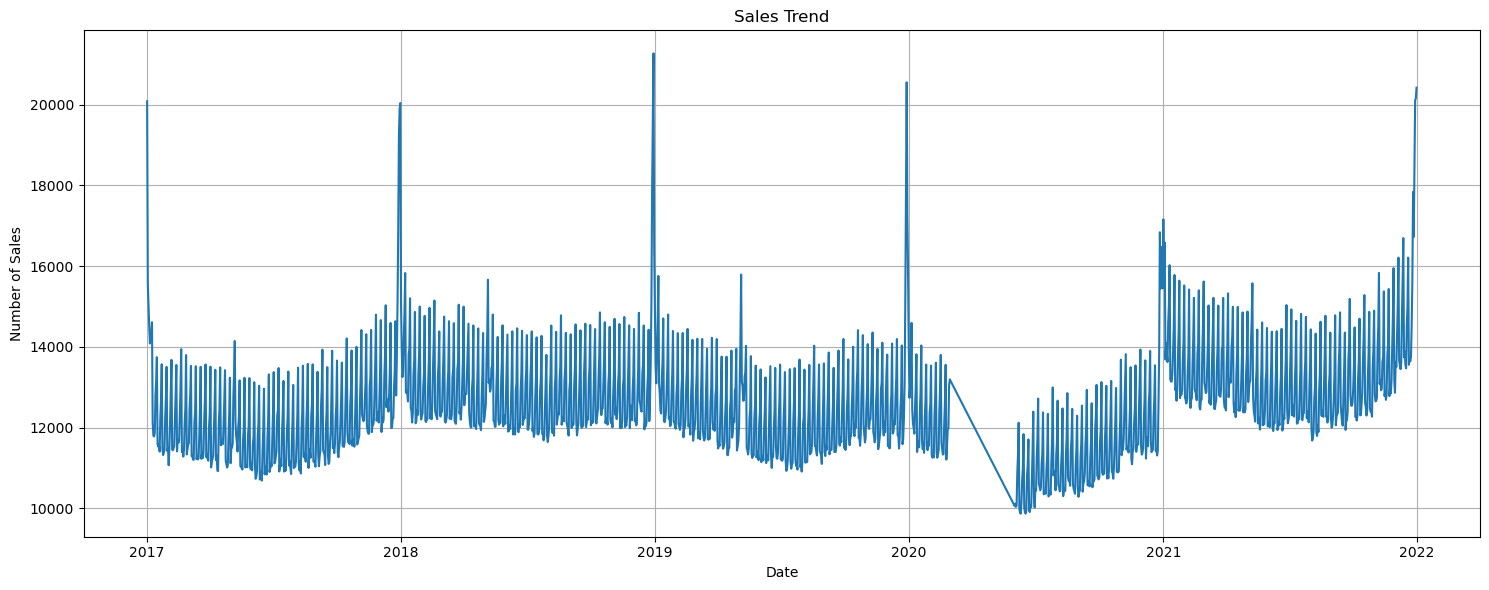

In [11]:
temp = train.loc[~((train["date"] >= "2020-03-01") & (train["date"] < "2020-06-01"))].copy()  # Remove data from March 2020 to May 2020
train_agg = temp.groupby("date")["num_sold"].sum().reset_index()


plt.figure(figsize=(15, 6))
sns.lineplot(data=train_agg, x="date", y="num_sold")
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.title("Sales Trend")
plt.grid(True)
plt.tight_layout()
plt.show()

### Intepret the Results 📊
1. **Filter the data: 🚰** The code creates a temporary DataFrame temp that excludes data from March 2020 to May 2020. This is done using the loc method with a condition that only includes rows where the 'date' is not between "2020-03-01" and "2020-06-01".

2. **Aggregate sales data: 📊** The code then aggregates the number of products sold (num_sold) for each unique date in the filtered data. This is done using the groupby method on the 'date' column and then applying the sum function on the 'num_sold' column. The result is a new DataFrame train_agg that has each unique date and the total number of products sold on that date.

3. **Plot the sales trend: 📈** Finally, the code creates a line plot to visualize the trend of product sales over time. The x-axis represents the date, and the y-axis represents the number of products sold. The title of the plot is "Sales Trend", and grid lines are added for easier visualization.

In [12]:
test_agg = test.groupby(['date'])['id'].first().reset_index().drop(columns='id')
test_dates = test_agg[['date']]

### Feature Engineering

In [13]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_AR = holidays.CountryHoliday('AR', years=years_list) # Argentina
    holiday_CA = holidays.CountryHoliday('CA', years=years_list) # Canada
    holiday_EE = holidays.CountryHoliday('EE', years=years_list) # Estonia
    holiday_JP = holidays.CountryHoliday('JP', years=years_list) # Japan
    holiday_ES = holidays.CountryHoliday('ES', years=years_list) # Spain

    holiday_dict = holiday_AR.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_EE)
    holiday_dict.update(holiday_JP)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')

    return df

# Assume enc is an instance of OrdinalEncoder()
def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else:
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = oe.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    return df

def apply_sin_cos_transformation(df, col_name, period):
    df[f'{col_name}_sin'] = np.sin(df[col_name] * (2 * np.pi / period))
    df[f'{col_name}_cos'] = np.cos(df[col_name] * (2 * np.pi / period))
    return df

def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12)) ## ?
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 365)) ## ? 
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    new_df["day_of_year"] = df["date"].dt.dayofyear

    #account for leap year
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    new_df["year"] = df["date"].dt.year
    
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    for day in list(range(-5, 5)) + list(range(40, 48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    
    for col in new_df.columns :
        if 'easter' in col :
            new_df = pd.get_dummies(new_df, columns = [col], drop_first=True)
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

#### ⚙️ Feature Engineering Explained
`get_holidays(df)`: 📅 This function identifies whether each date in the dataset is a holiday in one of the specified countries (Argentina, Canada, Estonia, Japan, or Spain) for the years 2017-2022. If a date is a holiday, it records the name of the holiday; otherwise, it records 'Not Holiday'. It also adds a binary 'is_holiday' column where 1 indicates a holiday and 0 indicates a non-holiday.

`encode_holiday_names(df, enc, subset='train'`:` 🔄 This function uses an ordinal encoder (enc) to transform the 'holiday_name' column to numerical values, making it suitable for machine learning algorithms. The encoding is fitted on the training data and then applied to the test data. Any new holiday names in the test data that the encoder has not seen in the training data are given the same code as 'Not Holiday'.

`apply_sin_cos_transformation(df, col_name, period)`: 🌀 This function applies a sinusoidal transformation to a specified column in the dataset. This is useful for dealing with cyclical features like time of day or day of year, as it preserves the cyclical nature of the data.

`feature_engineer(df)`: 🛠 This function applies a series of feature engineering steps to the dataset, including:

* Extracting the month, day, and day of the week from the 'date' column and applying a sinusoidal transformation to them.

- Creating a 'day_of_year' feature that accounts for leap years.

- Creating a 'important_dates' feature that records certain specified days of the year.

- Creating binary features for each year indicating whether it's 5 days before or after Easter, or 40-47 days after Easter.

- Dropping the 'date', 'month', 'day', and 'day_of_year' columns.

- One-hot encoding the 'important_dates' and 'day_of_week' features.

<html>
<head>
<style>
.note-box {
  border: 2px solid #f0ad4e; /* Change color as needed */
  border-radius: 5px; /* Rounded corners */
  padding: 15px; /* Spacing inside the box */
  margin: 10px 0; /* Spacing outside the box */
  background-color: #fcf8e3; /* Light background color */
}

.note-box p {
  margin: 0; /* Remove default margin of paragraph */
  color: #8a6d3b; /* Text color */
}

.note-box:before {
  content: "\26A0"; /* Unicode character for warning sign */
  color: #8a6d3b; /* Text color for the icon */
  font-weight: bold; /* Make the icon bold */
  display: inline-block; /* Allows us to add margin */
  margin-right: 10px; /* Spacing after the icon */
}
</style>
</head>
<body>

<div class="note-box">
  <p>📝Note: The get_holidays, encode_holiday_names, and apply_sin_cos_transformation functions are not called in the feature_engineer function, so you would need to call these functions separately on data before or after calling feature_engineer.</p>
</div>

</body>
</html>


> **🚧 Keep in Mind**
> 
> Overall, these functions are designed to extract and create features from the 'date' column that could be useful for a machine learning model. The specific features created depend on the dataset and the problem at hand, but generally, these transformations are intended to help a model capture patterns related to the time and date of the sales data. 🎯

### Encoding

In [14]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
train_agg = get_holidays(train_agg)
test_agg = get_holidays(test_agg)

train_pred = pd.DataFrame()
train_pred['date'] = train_agg['date']

y_train = train_agg['num_sold']
X_train = train_agg.drop(columns='num_sold')
X_test = test_agg

X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)

X_train = encode_holiday_names(X_train,oe)
X_test = encode_holiday_names(X_test,oe)


### Apply Model

In [21]:
def train_and_predict(X_train, y_train, X_test):
    preds_lst = []
    n_splits = 5
    kf = GroupKFold(n_splits=n_splits)
    scores = []
    train_scores = np.zeros(len(X_train))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.year)):
        model = LGBMRegressor(n_estimators=2000, learning_rate=0.01, num_leaves=50, random_state=42,verbosity=-1)
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[train_idx]), columns=X_train.columns)
        X_val_scaled = pd.DataFrame(scaler.transform(X_train.iloc[val_idx]), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        model.fit(X_train_scaled, y_train.iloc[train_idx])
        preds_lst.append(model.predict(X_test_scaled))
        train_scores[val_idx] = model.predict(X_val_scaled)
        sc = model.score(X_val_scaled, y_train.iloc[val_idx])
        scores.append(sc)
        print(f"Fold {fold}: Score = {sc}")

    mean_score = np.mean(scores)
    print("Mean score:", mean_score)
    return preds_lst, train_scores

preds_lst, train_scores = train_and_predict(X_train, y_train, X_test)
train_pred['num_sold'] = train_scores

Fold 0: Score = -1.1691114021064322
Fold 1: Score = 0.21475216488285287
Fold 2: Score = 0.3837103988566407
Fold 3: Score = 0.4885564360766419
Fold 4: Score = 0.45458782481895255
Mean score: 0.07449908450573117


#### Intepret the Results 📊
##### Process :
1. Initialize an empty list and variables: 📝 An empty list preds_lst and a zero-filled array train_scores of the same length as X_train are created to store the predictions for the test data and training data respectively.

2. GroupKFold Cross-validation: 🔀 A GroupKFold cross-validator is set up with 5 folds. The year column is used as the grouping variable. The GroupKFold cross-validator ensures that the same group is not represented in both the training set and validation set for each fold.

3. Model Training and Prediction: 🎯 For each fold, the following steps are performed:

    A. An instance of the LightGBM Regressor model (a type of gradient boosting model) is created with specified hyperparameters.

    B. StandardScaler is used to standardize the predictor variables by removing the mean and scaling to unit variance.

    C. The model is trained on the scaled training data for that fold.

    D. The model's predictions for the scaled test data are appended to preds_lst.

    E. The model's predictions for the scaled validation data are stored in train_scores.

    F. The score of the model on the validation data for that fold is printed. This score is the coefficient of determination  𝑅^2 of the prediction, which provides a measure of how well future samples are likely to be predicted by the model.

4. Calculate and Print Mean Score: 📈 The mean of the scores from each fold is calculated and printed. This gives an overall measure of how well the model performed across all folds of the cross-validation.

##### 🔨 Results Interpretation :
🔎 Here are some observations:

In this case, the output shows the  𝑅2 score for each fold and the mean score. The  𝑅2
scores vary greatly between folds, with the first fold having a negative score. Negative  𝑅2
 indicates that the model performs worse than a horizontal line. The mean  𝑅2 score is also negative, suggesting that the model's predictions are, on average, worse than a horizontal line. This suggests that the model may not be fitting the data well and could benefit from further tuning or a different modeling approach. 🛠

After the function is run, the predictions for the training data are added to the train_pred DataFrame under the column 'num_sold'. The preds_lst is a list of prediction arrays for the test data from each fold of the cross-validation. 🔍

#### Actual VS Predicted

In [25]:
preds_df = pd.DataFrame(
    np.column_stack(preds_lst),
    columns=["2017","2018","2019","2020","2021"]
)
# Calculate average predictions from k-fold
preds_df['num_sold'] = preds_df.mean(axis=1)

# Assign predictions to test_dates DataFrame
test_dates["num_sold"] = preds_df['num_sold']

In [27]:
test_dates

,date,num_sold
0,2022-01-01,15793.673162
1,2022-01-02,15901.557826
2,2022-01-03,13671.741949
3,2022-01-04,13464.071581
4,2022-01-05,13552.397206
...,...,...
360,2022-12-27,17070.739667
361,2022-12-28,17641.760937
362,2022-12-29,18681.349272
363,2022-12-30,18900.889993


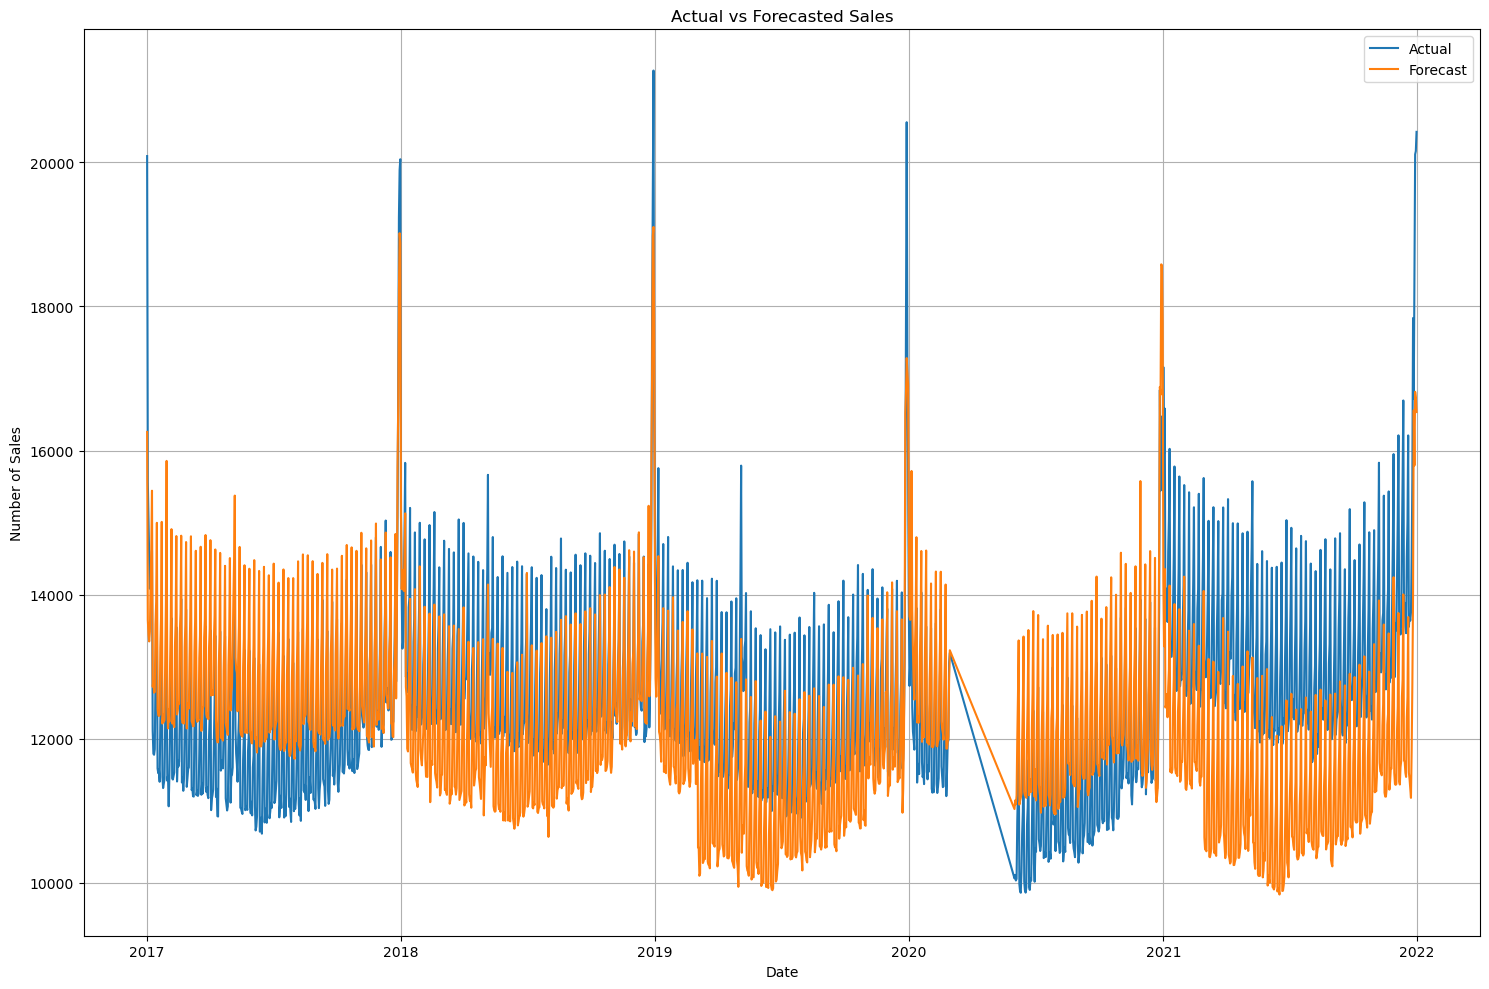

In [28]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="date", y="num_sold", label='Actual')
sns.lineplot(data=train_pred, x='date', y='num_sold', label="Forecast")
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Actual vs Forecasted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Predicted Values


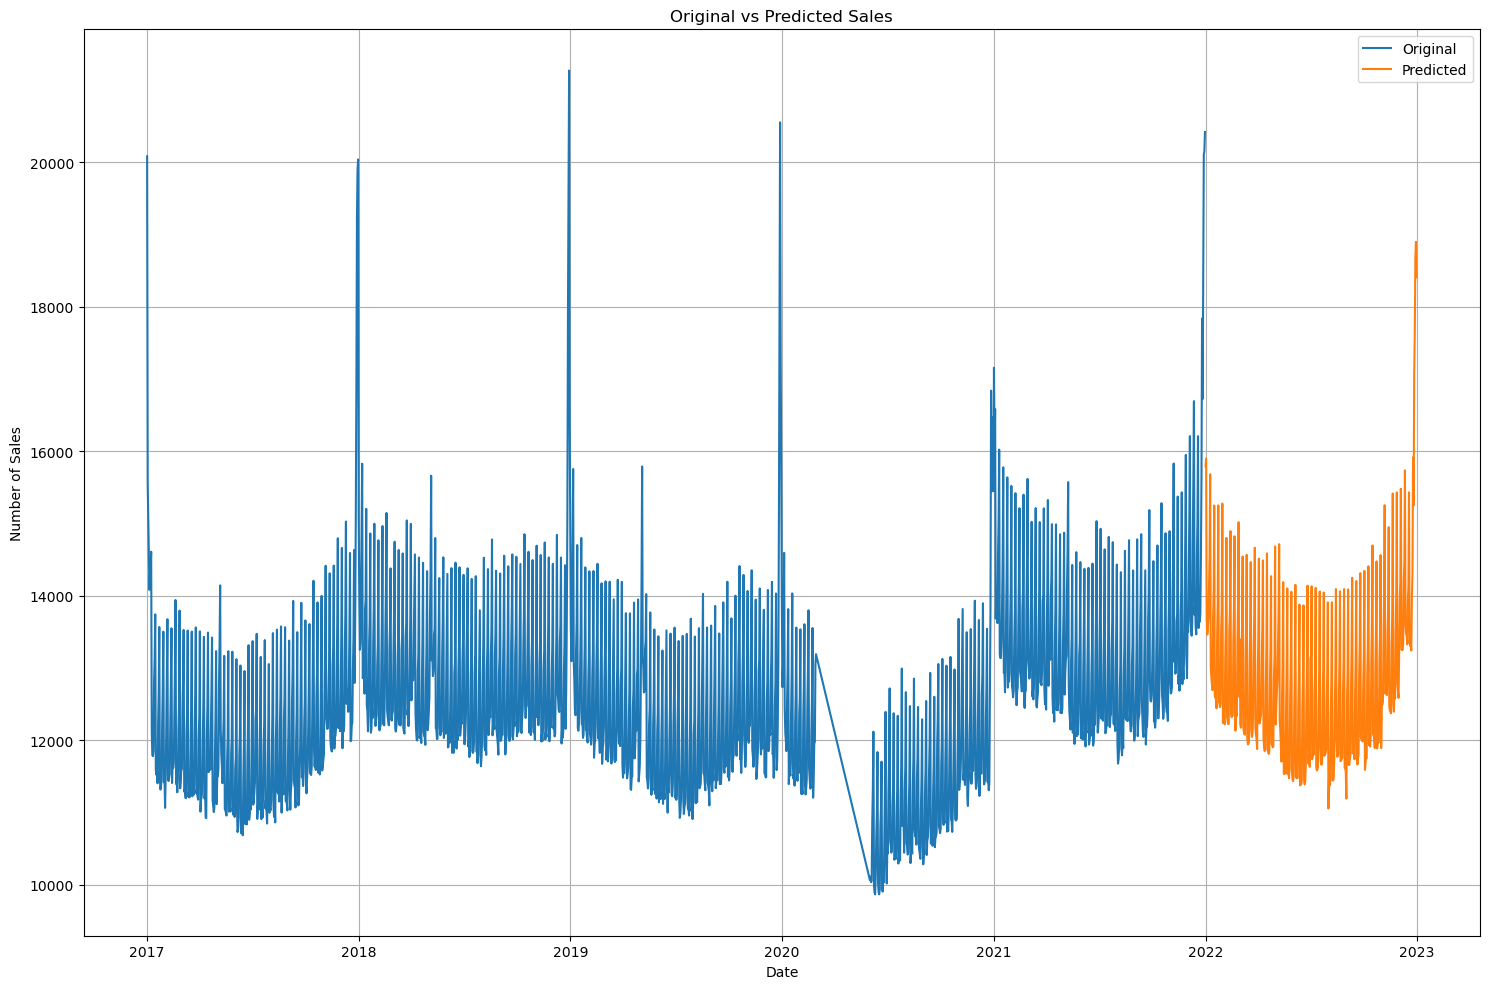

In [30]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="date", y="num_sold", label='Original')
sns.lineplot(data=test_dates, x="date", y="num_sold", label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Original vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot Product Ratio

In [53]:
product_df = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df

,date,product,ratios
0,2017-01-01,Using LLMs to Improve Your Coding,0.255452
1,2017-01-01,Using LLMs to Train More LLMs,0.254058
2,2017-01-01,Using LLMs to Win Friends and Influence People,0.039381
3,2017-01-01,Using LLMs to Win More Kaggle Competitions,0.253211
4,2017-01-01,Using LLMs to Write Better,0.197899
...,...,...,...
9125,2021-12-31,Using LLMs to Improve Your Coding,0.263001
9126,2021-12-31,Using LLMs to Train More LLMs,0.263686
9127,2021-12-31,Using LLMs to Win Friends and Influence People,0.039957
9128,2021-12-31,Using LLMs to Win More Kaggle Competitions,0.241015


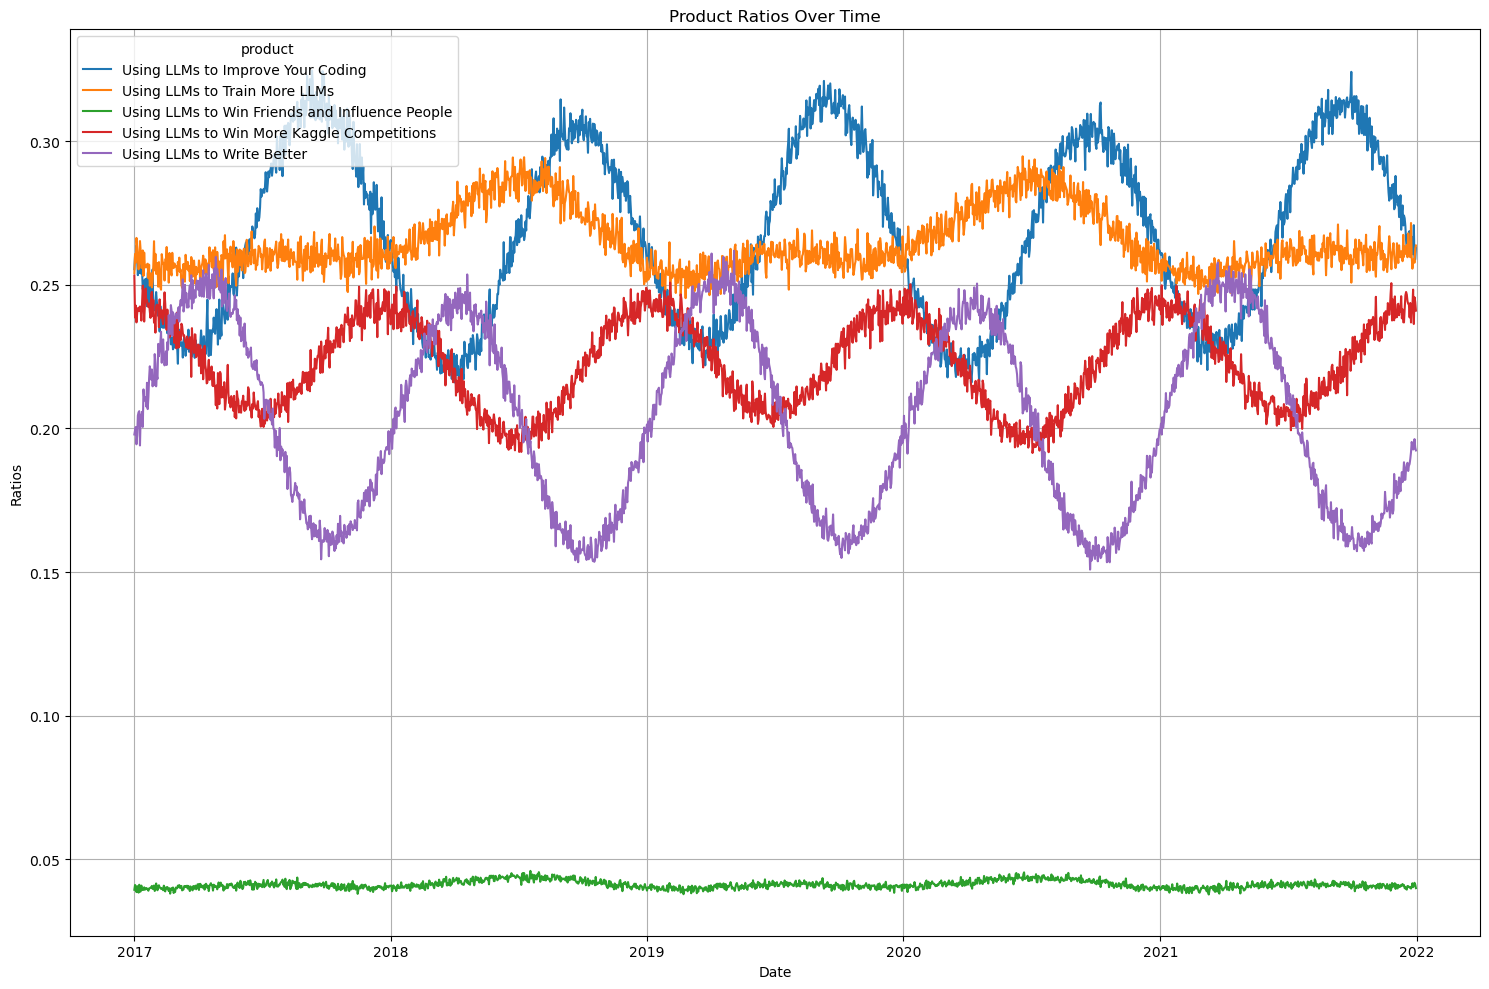

In [54]:
temp_df = pd.concat([product_ratio_df,test_agg]).reset_index(drop=True)
plt.figure(figsize=(15, 10))
sns.lineplot(data=temp_df, x="date", y="ratios", hue="product")
plt.xlabel("Date")
plt.ylabel("Ratios")
plt.title("Product Ratios Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

**🍽️ Process :**
1. Concatenate DataFrames: ➕ The code concatenates the product_ratio_df DataFrame (which contains the ratio of sales for each product for each date in the training data) and the test_agg DataFrame (which contains the unique dates in the test data). The result is a new DataFrame temp_df that contains both the training and testing dates.

2. Visualize Product Ratios Over Time: 📈 Then, a line plot is created to visualize the product ratios over time. The x-axis represents the date, and the y-axis represents the ratios. Each product is represented by a different line, distinguished by color. The title of the plot is "Product Ratios Over Time", and grid lines are added for easier visualization.

### Calculate Mean Ratio

In [56]:
mean_ratios = []
years = train['Year'].unique()
years.sort()  # ensuring years are sorted
years = years[:-2]  # remove last two years
assert len(years) > 0, "There should be at least one year to compute mean_ratios"

weights = [0.2, 0.4, 0.4]  # you can change these weights according to your need
assert len(weights) == len(years), "Weights count should match with the years count"

for year in years:
    product_ratio_2019 = product_ratio_df.loc[product_ratio_df["date"].dt.year == year].copy()
    product_ratio_2019["mm-dd"] = product_ratio_2019["date"].dt.strftime('%m-%d')
    product_ratio_2019 = product_ratio_2019.drop(columns="date")
    product_ratio_2019 = product_ratio_2019.reset_index()
    mean_ratios.append(product_ratio_2019['ratios'])

product_ratio_test = test.copy()

# Now product_ratio_2019 is defined and can be used here
product_ratio_2019['mean_ratios'] = sum(mean_ratio * weight for mean_ratio, weight in zip(mean_ratios, weights))

product_ratio_test["mm-dd"] = product_ratio_test["date"].dt.strftime('%m-%d')
product_ratio_test = pd.merge(product_ratio_test, product_ratio_2019, how="left", on=["mm-dd", "product"])
product_ratio_test

,id,date,country,store,product,Year,Month,Day,WeekDay,mm-dd,index,ratios,mean_ratios
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,01-01,3650,0.256706,0.260007
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,01-01,3651,0.259442,0.258146
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,01-01,3652,0.039103,0.039814
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,01-01,3653,0.243360,0.242481
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,01-01,3654,0.201388,0.199552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,12-31,5470,0.260448,0.260866
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,12-31,5471,0.266844,0.258673
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,12-31,5472,0.041223,0.040659
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,12-31,5473,0.236449,0.242341


#### ✏️ Process :¶
1. Prepare mean_ratios: 📝 First, get the unique years from the 'Year' column of the train DataFrame, sorts them, and removes the last two years. An assertion check is done to ensure there are years to compute the mean_ratios. It also defines a set of weights and does an assertion check to ensure the count of weights matches the count of years.

2. Compute yearly ratios: 🗓 For each year in the list of years, the code gets the corresponding rows from the product_ratio_df DataFrame. Then it adds a new column 'mm-dd' which is the month and day of the date. The 'date' column is then dropped and the DataFrame is reset. The ratios for the year are then appended to the mean_ratios list.

3. Calculate mean_ratios: 🧮 The mean_ratios for the last extracted year's DataFrame is computed as a weighted sum of the ratios in mean_ratios and the weights.

4. Prepare the test DataFrame: 📋 The test DataFrame is copied to product_ratio_test and a new column 'mm-dd' is added which is the month and day of the date.

5. Merge the DataFrames: ➕ product_ratio_test is then merged with product_ratio_year on the 'mm-dd' and 'product' columns. This results in a DataFrame that contains the original columns from the test DataFrame, as well as the calculated mean_ratios for each product for each date.

In [70]:
test_data = pd.merge(test, test_dates, how="left")
test_data["ratios"] = product_ratio_test["mean_ratios"]
test_data

,id,date,country,store,product,Year,Month,Day,WeekDay,num_sold,ratios
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,15793.673162,0.260007
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,15793.673162,0.258146
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,15793.673162,0.039814
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,15793.673162,0.242481
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,15793.673162,0.199552
...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,18410.117611,0.260866
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,18410.117611,0.258673
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,18410.117611,0.040659
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,18410.117611,0.242341


### Make a Prediction

In [72]:
def disaggregate_forecast(df, original_data):
    new_df = df.copy()

    total_num_sold = original_data["num_sold"].sum()

    stores_weights = original_data.groupby("store")["num_sold"].sum() / total_num_sold

    # Compute country_weights and check if all countries in df are present in original_data
    unique_countries = df["country"].unique()

    country_weights = pd.Series(index=unique_countries, data=1/len(unique_countries))

    # Adjust num_sold based on country and store weights
    for country in country_weights.index:
        new_df.loc[new_df["country"] == country, "num_sold"] *= country_weights[country]
        
    for store in stores_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] *= stores_weights[store]

SyntaxError: incomplete input (3120250961.py, line 1)